# Paytm

In [53]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/paytm/paytm.csv', engine='python')

In [30]:
# Company username
company_username = 'Paytmcare'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
df = df[~df['date'].str.contains("http", na=False)]

In [6]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [7]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [8]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [33]:
qdf.shape

(3459, 28)

In [34]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 3358


In [35]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [36]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [38]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

0it [00:00, ?it/s]

In [39]:
result

,conversation_id,response_time
0,1344016717694042114,1.860833
1,1344186330482262016,0.860000
2,1343909218022117378,0.000000
3,1343164305173147648,0.015556
4,1341356011563565059,4.873333
...,...,...
3353,1080341597475106816,0.000000
3354,1080108275478204421,0.000000
3355,1080103861594013696,0.000000
3356,1080034600405983233,0.000000


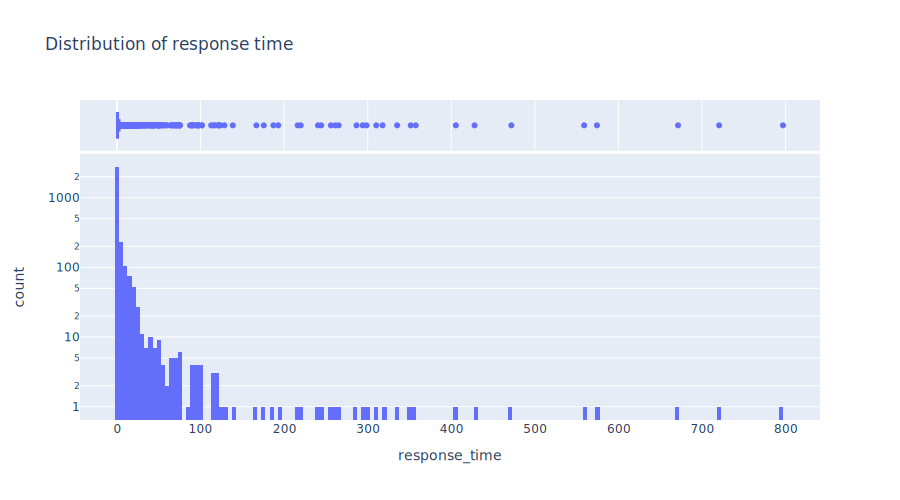

In [40]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [41]:
result['resolution_time'] = 0

In [43]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

0it [00:00, ?it/s]

In [44]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 1897
Number of queries unresolved: 1461


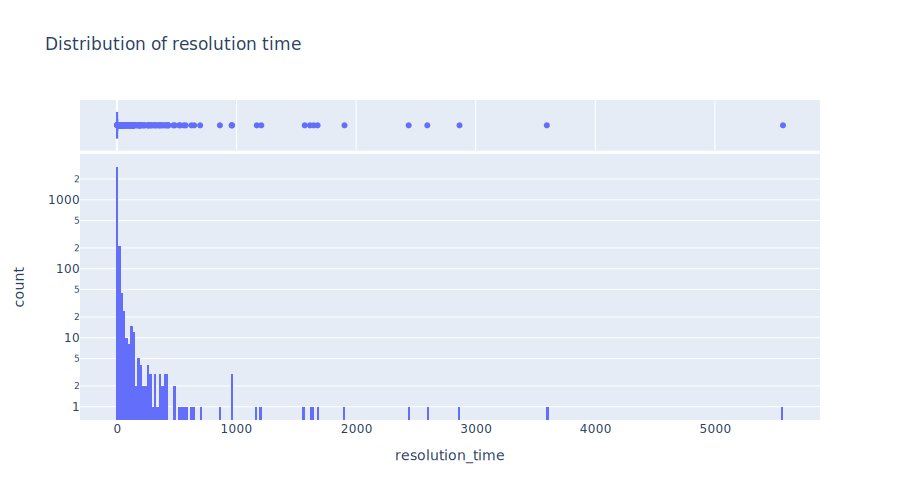

In [45]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [46]:
result.describe()

,response_time,resolution_time
count,3358.000000,3358.000000
mean,8.922587,18.402760
std,83.857372,164.904065
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.236806,0.148333
75%,1.241319,1.362917
max,3356.318056,5569.472222


## Query Tweets Topics

In [94]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]
queries.shape


(2070, 28)

In [95]:
processor = Processor('./../../data/config.json')
pre_queries, post_queries = processor.preprocess(queries)
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]


In [96]:
pre_queries.shape


(1394, 31)

In [97]:
post_queries.shape


(548, 31)

In [101]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.6,
                                        eta=0.3)
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [102]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.002270 -0.102864       1        1  29.048539
2      0.082228  0.068888       2        1  23.878228
0     -0.109945  0.049430       3        1  23.859098
3      0.029987 -0.015454       4        1  23.214134, topic_info=         Term        Freq       Total Category  logprob  loglift
56     wallet  101.000000  101.000000  Default  30.0000  30.0000
291  postpaid  275.000000  275.000000  Default  29.0000  29.0000
242    refund   78.000000   78.000000  Default  28.0000  28.0000
304   balance   51.000000   51.000000  Default  27.0000  27.0000
125  received   49.000000   49.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
737   working   14.245127   66.430253   Topic4  -5.5383  -0.0793
158      days   13.913438   70.021338   Topic4  -5.5619  -0.1555
113  able_use   12.260206   35.818951   Topic4  -5.6884   0.3883
33   cashback   12.676207   58.490017   Topic4  -5.6550  -0.0687
70     ticket   12.288020   39.989272   Topic4  -5.6861   0.2804

[299 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
518       1  0.390905      able
518       2  0.533052      able
518       3  0.017768      able
518       4  0.053305      able
113       1  0.195427  able_use
...     ...       ...       ...
239       3  0.628224      year
239       4  0.052352      year
40        1  0.080178    zomato
40        2  0.080178    zomato
40        3  0.801783    zomato

[573 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [103]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())

In [104]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['postpaid, card, days, received, payment, team, membership, fraud, app, working',
       'app, account, kyc, payment, postpaid, time, money, limit, pay, showing',
       'postpaid, wallet, help, payment, balance, cashback, account, order, able, money',
       'postpaid, refund, money, dont, payment, use, help, offer, issue, recharge'],
      dtype=object)

Pre-COVID following topics can be seen:
1. Paytm postpaid issues
2. KYC issues
3. Wallet and cashback issues
4. Payment related issues on third-party sites

In [105]:
# select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
# pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



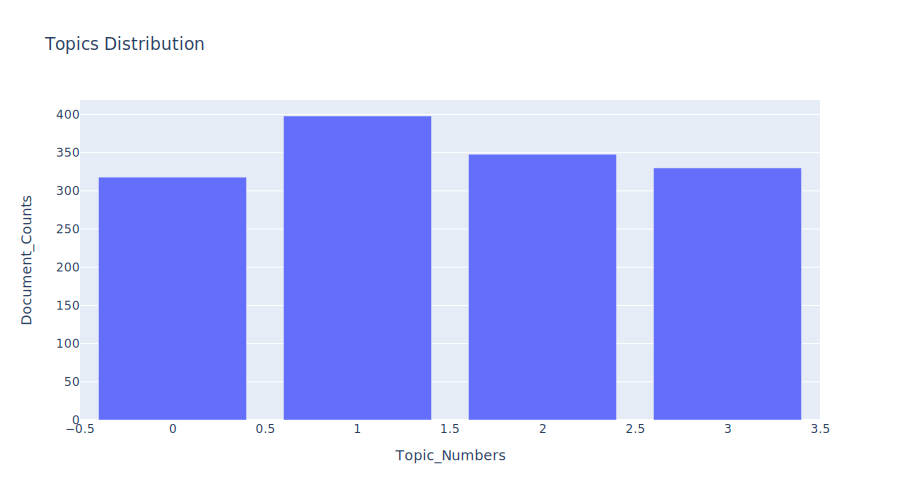

In [106]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()


In [109]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [110]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.099939  0.009520       1        1  42.67117
1      0.041069 -0.084931       2        1  32.67294
0      0.058870  0.075411       3        1  24.65589, topic_info=         Term        Freq       Total Category  logprob  loglift
9     account   64.000000   64.000000  Default  30.0000  30.0000
242  postpaid  112.000000  112.000000  Default  29.0000  29.0000
27        app   59.000000   59.000000  Default  28.0000  28.0000
216       use   41.000000   41.000000  Default  27.0000  27.0000
50     offers   11.000000   11.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
352   support    5.057694   14.399095   Topic3  -5.6731   0.3539
106   payment    6.400295   52.629292   Topic3  -5.4377  -0.7068
129  customer    5.326433   25.357917   Topic3  -5.6213  -0.1603
242  postpaid    5.708206  112.018562   Topic3  -5.5521  -1.5766
54      money    4.968116   57.237554   Topic3  -5.6910  -1.0440

[224 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
287       1  0.305917       ac
287       2  0.611834       ac
287       3  0.076479       ac
9         1  0.885297  account
9         2  0.108721  account
...     ...       ...      ...
271       2  0.334749  working
271       3  0.418437  working
418       2  0.988226  writing
108       2  0.342255   zomato
108       3  0.684509   zomato

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [112]:

post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())



In [113]:
post_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['postpaid, account, money, use, payment, pay, app, service, hey, dont',
       'wallet, payment, postpaid, recharge, showing, paid, received, bank, help, card',
       'app, credit_card, offer, offers, got, dont, received, food, option, membership'],
      dtype=object)

Following topics were discussed post pandemic:
1. Postpaid related issues
2. Wallet related issues
3. Offer related issues

In [116]:
# select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
# post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



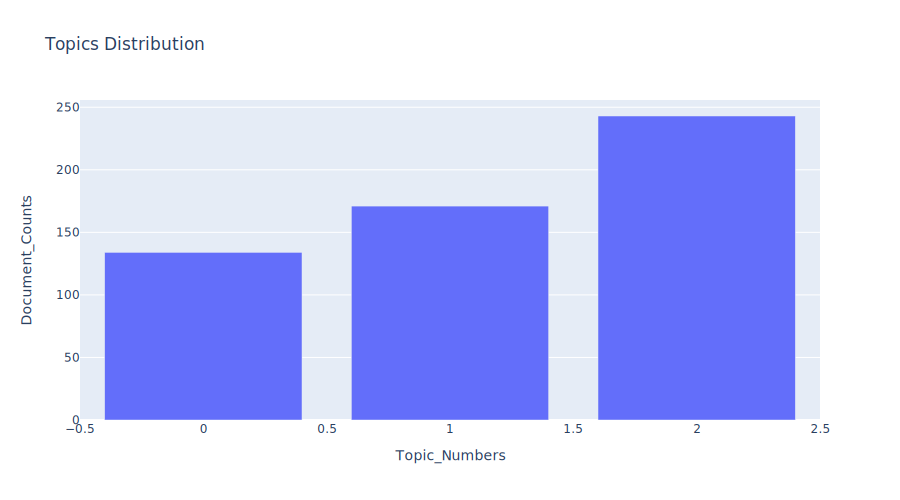

In [115]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()
